## Boiler Plate

# FastAI_StarterScript Notebook for Azure ML
This notebook is modified from FastAI_StarterScript Notebook to make it runnable in Azure ML workspace.

If you run this notebook for the first time or you use a new compute instance, you need to install all required libraries. 
You can open the console and use the following commands to install the required python library.

```bash
pip install -r requirements.txt 
pip install -U torch torchaudio --no-cache-dir
```

You also need to modify `output_root_folder` varialbe so it align with your intended output data folder path

In [1]:
%reload_ext autoreload
#%autorel/oad 2
%matplotlib inline

In [4]:
import os
import pandas as pd
from azureml.core import Workspace, Dataset
import mlflow
import matplotlib.pyplot as plt
# Connect to Workspace and reference Dataset
ws = Workspace.from_config()

In [3]:
from fastai.vision import *
from fastai.callbacks import CSVLogger, SaveModelCallback

In [3]:
from audio import * ## Imporing FastAI Audio Library
from tqdm import tqdm_notebook ## For progress bars

In [5]:
# Configure output folder path. 

# ! You need to modify this path to align with your local folder structure becuase it include {user name} here. 
output_root_folder="/mnt/batch/tasks/shared/LS_root/mounts/clusters/herman-gpu/code/Users/herman.wu/"
ml_experiment_name="orca-sound-resnet18-round1to3-FASTAI"
model_folder_name="models"
eval_pred_folder_name="eval_pred"


In [6]:
train_dataset_name="orcahello-audio-round1to3"
test_dataset_name="orcahello-audio-testdata-round1to3"
benchmark_dataset_name="orcahello-audio-perf-benchmark-data"   # test2Sec
model_final_eval_dataset_name="orcahello-model-eval-testdata-01"  #TestDataLatest_PodCastAllRounds
model_file_name="stg2-rn18.pkl"
submission_file_name='submission2SecFastAI.csv'


In [6]:
# Connect to Workspace and reference Dataset
ws = Workspace.from_config()
dataset = ws.datasets[train_dataset_name]

# Create mountcontext and mount the dataset
mount_ctx = dataset.mount()  
mount_ctx.start()  

# Get the mount point
dataset_mount_folder = mount_ctx.mount_point
print(dataset_mount_folder)


Volume mount is not enabled. 
Falling back to dataflow mount.
/tmp/tmpsyn24ujg


In [7]:
# List the files in the mount point
files = os.listdir(dataset_mount_folder)
print(files)

['models', 'negative', 'positive']


In [8]:
from azureml.core import Workspace
import mlflow
from mlflow.tracking import MlflowClient

ws = Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

mlflow.create_experiment(ml_experiment_name)
mlflow.set_experiment(ml_experiment_name)
mlflow_run = mlflow.start_run()

In [9]:
## Unzipping data and moving it in right location
#!p7zip -d ./data/all.7z
#!mkdir data
#!mv negative data/
#!mv positive data/

## Importing Library and Helper functions

In [11]:
## Helper functions for model evaluation

## Taken from my cookbooks - https://github.com/aayushmnit/cookbook/blob/master/ml_classification.py
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    f1_score
)

def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Data Check

This step just checks data and provide some summary statistics like sampling rate of different audio clips and length distribution of each waveFile

In [12]:
## Defining path of modeling related data (Contains two folder positive and negative)
#data_folder = Path("./data/train/mldata/all/") 
data_folder = Path(dataset_mount_folder) # Adjust folder path for Azure ML 
audios = AudioList.from_folder(data_folder)
#len_dict = audios.stats(prec=1)

## Load Data

In [13]:
## Definining Audio config needed to create on the fly mel spectograms
config = AudioConfig(standardize=False, 
                     sg_cfg=SpectrogramConfig(
                         f_min=0.0,  ## Minimum frequency to Display
                         f_max=10000, ## Maximum Frequency to Display
                         hop_length=256,
                         n_fft=2560, ## Number of Samples for Fourier
                         n_mels=256, ## Mel bins
                         pad=0, 
                         to_db_scale=True, ## Converting to DB sclae
                         top_db=100,  ## Top decible sound
                         win_length=None, 
                         n_mfcc=20)
                    )
config.duration = 4000 ## 4 sec padding or snip
config.resample_to=20000 ## Every sample at 20000 frequency

params = {
"f_min":0.0,  ## Minimum frequency to Display,
"f_max":10000, ## Maximum Frequency to Display
"hop_length":256,
"n_fft":2560, ## Number of Samples for Fourier
"n_mels":256, ## Mel bins
"pad":0, 
"to_db_scale":"True", ## Converting to DB sclae
"top_db":100,  ## Top decible sound
"win_length":"None", 
"n_mfcc":20,
"duration":4000,
"resample_to":200000,
"standardize":"False",
"train_dataset_name":"orcahello-audio-round1to3",
"test_dataset_name":"orcahello-audio-testdata-round1to3",
"benchmark_dataset_name":"orcahello-audio-perf-benchmark-data",
"model_file_name":"stg2-rn18.pkl",
"submission_file_name":'submission2SecFastAI.csv',
"ml_framework1":"pytorch",
"ml_framework2":"fastai",
"base_model":"ResNet18",
"notebook": "2_FastAI_StarterScript-AML.ipynb"
}

mlflow.log_params(params)
mlflow.log_dict(params,"parameters.json")
mlflow.set_tags(params)

config

AudioConfig(cache=True, duration=4000, max_to_pad=None, pad_mode='zeros', remove_silence=None, use_spectro=True, mfcc=False, delta=False, silence_padding=200, silence_threshold=20, segment_size=None, resample_to=20000, standardize=False, downmix=False, sg_cfg=SpectrogramConfig(f_min=0.0, f_max=10000, hop_length=256, n_fft=2560, n_mels=256, pad=0, to_db_scale=True, top_db=100, win_length=None, n_mfcc=20))

**HyperParameter Cheat Sheet - Taken from [here](https://nbviewer.jupyter.org/github/mogwai/fastai_audio/blob/master/tutorials/01_Intro_to_Audio.ipynb)**
- sample_rate, This is not the place to change this, you are just telling librosa what your sample rate is. Usually it is predetermined for you by your dataset but check the resampling section for more info on changing this.
- fmin, minimum frequency to display in spectrogram, this should be low, anything 0-20 seems to work well
- fmax, maximum frequency to display. This should generally be 1/2 of your sample rate, but can be set to 8000 for speech.
- n_mels, How many mel bins to use, this will determine number of pixels tall your sg is. 64-128 are good defaults, but try various values, bigger isn't always better, test for your dataset. Some evidence suggests upscaling the image to a larger size is more effective than
- n_fft, The number of samples you use each time you compute a Fourier Transform. This is the width of the window and hop_length is how much you move the window each step. Increasing n_fft will increase frequency (y-axis) resolution to a point, powers of 2 are faster. Also dependent somewhat on n_mels so 20*n_mels is a common value as less than this can produce empty mel bins (black horizontal lines on sg)
- hop_length, the number of samples between successive frames of your sg. Determines width of image (# samples/hop = width in pixels). Good defaults really depend on dataset and the duration of audio your sg's represent (if they are longer, a larger hop is required to fit on a gpu, but you will be compressing the data). If you go too small, you can get blurring. Anything 64-512 can be good depending on context.
- top_db, Distance between loudest and softest sound you want displayed in spectrogram. If you choose 50db, the brightest pixel will be 50db, and anything that is 50+db lower than that won't be displayed. 80-120 is good.
- power, Honestly not entirely sure how this works. It's set to 1 for "energy" spectrogram and 2 for "power" spectrogram. An energy spectrogram is more detailed (less energy required to show up on the sg) but you don't generally have to worry about this because if you are converting to decibels (you'll do this almost always) it is factored out.

This code creates a AudioDataLoader and split data in random 80/20 split and takes the label from the folder name

In [14]:
## Creating Data Loader
audios = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_folder()

Preprocessing: Resampling to 20000


Preprocessing: Resampling to 20000


This code creates a AudioDataBunch which apply defined transformations (In our case frequency masking) on the fly and provide input spectograms to the model in defined bactch size (64) 

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_0_4.296791297654425_call.wav-6978ed1d8fceff870d57f48302320f10/0.wav
Total Length: 4.3 seconds
Number of Channels: 1
Label: negative
0.15s-4.15s of original clip


Channel 0.0 (256x312):


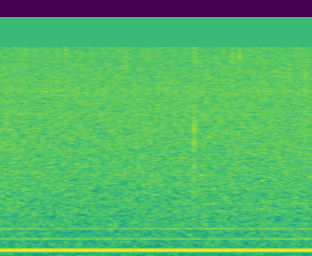

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_10_13.808922983941097_call.wav-05283a3da98bc157a12509eb0a36b9c1/0.wav
Total Length: 3.81 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


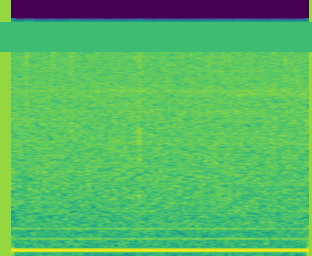

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_12_15.544734525415583_call.wav-896d2a2f33886409e92a5142837b86c5/0.wav
Total Length: 3.54 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


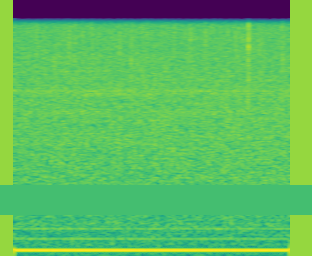

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_14_18.325273622301378_call.wav-198e8052425645aa6c4a77d546216c59/0.wav
Total Length: 4.33 seconds
Number of Channels: 1
Label: negative
0.18s-4.18s of original clip


Channel 0.0 (256x312):


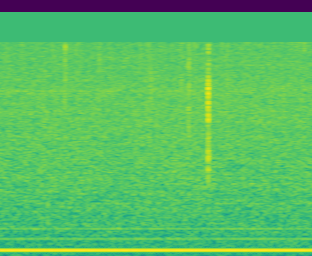

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_15_19.53185763087462_call.wav-ad5be3a8a60c1f9886a530beb489542b/0.wav
Total Length: 4.53 seconds
Number of Channels: 1
Label: negative
0.09s-4.09s of original clip


Channel 0.0 (256x312):


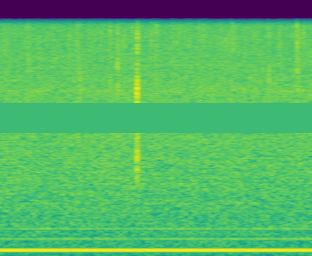

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_16_19.809099479334705_call.wav-5dea902b493d4c7b3eb96d2005666c02/0.wav
Total Length: 3.81 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


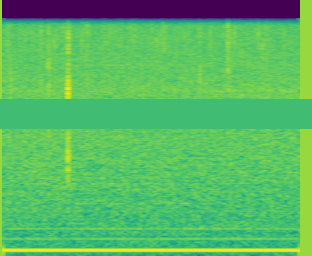

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_19_23.792778509777595_call.wav-2feb646659b8382d09804c0fdf034541/0.wav
Total Length: 4.79 seconds
Number of Channels: 1
Label: negative
0.09s-4.09s of original clip


Channel 0.0 (256x312):


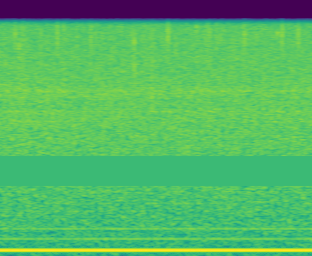

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_20_23.46800810459743_call.wav-6ff48ffb350b2674e890a771ed57a612/0.wav
Total Length: 3.47 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


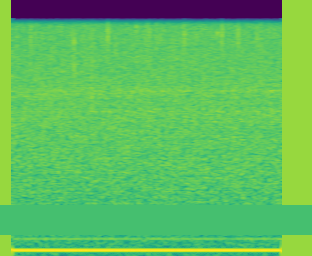

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_21_23.102946847420696_call.wav-7dcf9d173daa1382017786fd6bfe9ca5/0.wav
Total Length: 2.1 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


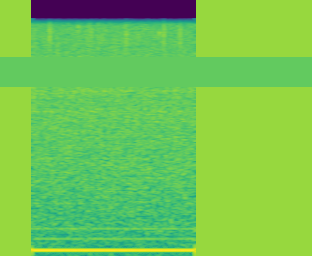

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_22_26.534191853566803_call.wav-ded3e8f25c6a7c8a99820aeca6dfd9f0/0.wav
Total Length: 4.53 seconds
Number of Channels: 1
Label: negative
0.44s-4.44s of original clip


Channel 0.0 (256x312):


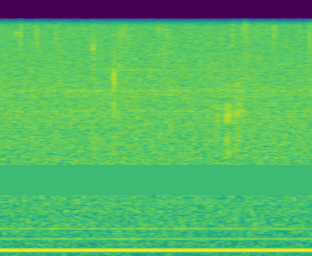

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_23_25.14857796862683_call.wav-eaf598082ac7cf9da3df62cc2e47384c/0.wav
Total Length: 2.15 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


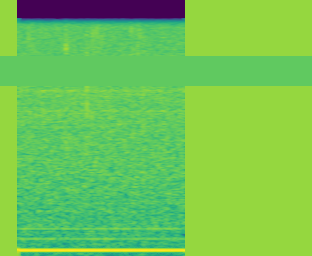

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_25_28.896390013775978_call.wav-7a0374b6cf530e832f81e6f8d1a9075f/0.wav
Total Length: 3.9 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


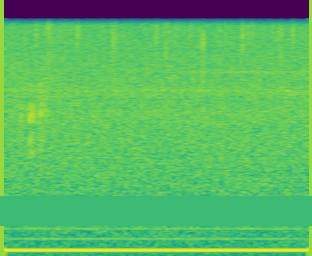

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_26_29.51296916381502_call.wav-be8b35b9e20bb83cd7438844684a7f64/0.wav
Total Length: 3.51 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


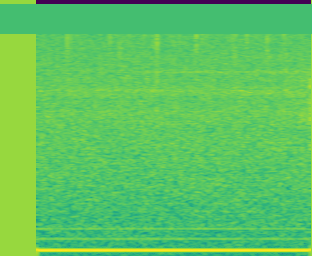

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_29_33.92646341949266_call.wav-8d18d6eac8cc678b133e1b8cfb049998/0.wav
Total Length: 4.93 seconds
Number of Channels: 1
Label: negative
0.77s-4.77s of original clip


Channel 0.0 (256x312):


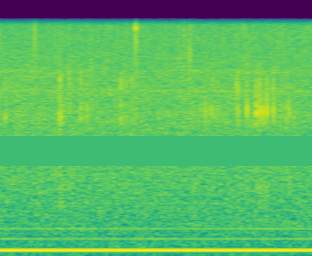

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_30_33.64908914312955_call.wav-96c86afca2b8e9b8dc12170cc6c3e288/0.wav
Total Length: 3.65 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


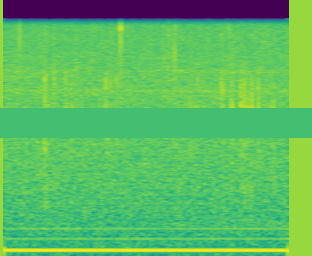

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_31_35.22289183896183_call.wav-47982c2a6111fd7ed4a8a8323bfd361d/0.wav
Total Length: 4.22 seconds
Number of Channels: 1
Label: negative
0.0s-4.0s of original clip


Channel 0.0 (256x312):


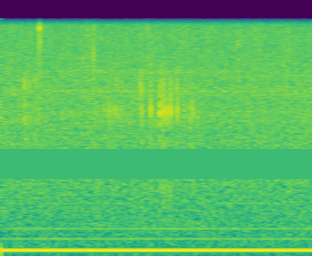

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_32_34.18558000946197_call.wav-7ddba069e8a3e0ba1780ab9f43fe09a2/0.wav
Total Length: 2.19 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


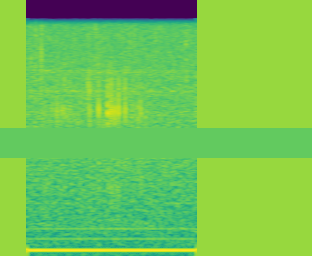

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_33_35.115230489753614_call.wav-592e65481a4940cb79769b9180d7b457/0.wav
Total Length: 2.12 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


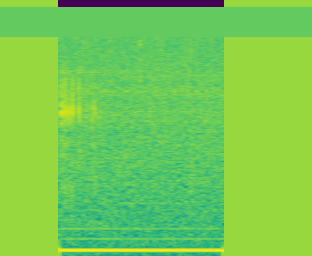

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_3_5.303029385701035_call.wav-75d0439f749df0ccaf8f76817271016c/0.wav
Total Length: 2.3 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


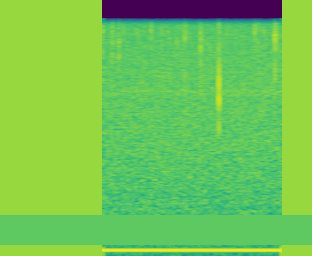

------------------------------------------------------------
File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_6_9.850985705036603_call.wav-636706d12a7a49404c7081a0937e700b/0.wav
Total Length: 3.85 seconds
Number of Channels: 1
Label: negative


Channel 0.0 (256x312):


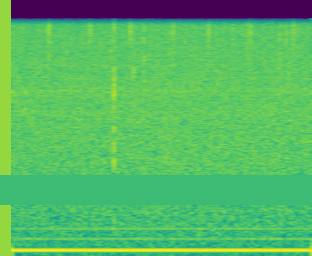

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1281) may be set too low.
  warnings.warn(


In [15]:
## Defining Transformation
tfms = None

## Frequency masking:ON
tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False) 

## Creating a databunch
db = audios.transform(tfms).databunch(bs=64)

## Let's insepect some data
db.show_batch(20)

## Model Training

Code below creates a ResNet18 model, removes the last 2 fully connected layer and then add new fully connected layers and load the pretrained weights from ImageNet Training.

In [16]:


mlflow.log_text("Code below creates a ResNet18 model, removes the last 2 fully connected layer and then add new fully connected layers and load the pretrained weights from ImageNet Training.", "models/model-description.txt")


In [17]:
## Default learner is ResNet 18 

#hist_csv = Path(os.path.join(output_root_folder,log_folder_name,log_file)) 
#print(hist_csv)
learn = audio_learner(db)
#learn = audio_learner(db, callbacks=[CSVLogger(learn,hist_csv, append=True)])
# learn = audio_learner(db, callbacks=[CSVLogger(learn)])

This is key feature of FastAI library, this helps us find the ideal learning rate by running model on sample data to see how the accuracy progresses. Output of this step is a learning rate curve (Choose the learning rate where loss starts bumping again)

In [18]:
## Find ideal learning rate
learn.model_dir=os.path.join(output_root_folder,model_folder_name) # change mode folder for Azure ML
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Training model, two cool things to highlight - 
- **This model is getting trained using [1 cycle learning policy]**(https://arxiv.org/abs/1803.09820) which leads to faster conversion, Here is a [cool blog](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) explaing the same if you are not a paper person
- **Differential learning rate** - You want different learning rate for different layer of models. In transfer learning you don't want to change learning rate of early layers as fast as later layers in network. (The slice function allows us to pass that information in FastAI)

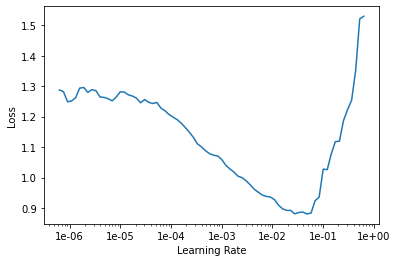

In [19]:
learn.recorder.plot()
plt.savefig('lr_plot_fastai-1-0d.png')
mlflow.log_artifact("lr_plot_fastai-1-0d.png", artifact_path="learning-rate")
# mlflow.log_figure(plt, "lr_plot_fastai-1-0c.html")

In [20]:
## 1-cycle learning (5 epochs and variable learning rate)
# learn = audio_learner(db, callbacks=[CSVLogger(learn,hist_csv, append=True)])
learn.fit_one_cycle(5, slice(2e-3, 2e-2))

FastAI outputs the model training porgress per epoch, Note that the accuracy is only calculated on Validation set (20% holdout set created during creating AudioDatabunch)

In [21]:
## Find ideal learning rate
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


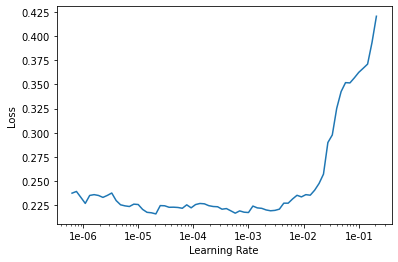

In [23]:
learn.recorder.plot()
plt.savefig('lr_plot_fastai-2.png')
mlflow.log_artifact("lr_plot_fastai-2.png", artifact_path="learning-rate")
# mlflow.log_figure(plt, "lr_plot_fastai-2a.png", artifact_path="learning-rate")

In [24]:
## 1-cycle learning (5 epochs and variable learning rate)
learn.fit_one_cycle(5, slice(1e-5, 1e-3))

In [25]:
## Exporting the model
learn.export(os.path.join(output_root_folder,model_folder_name,model_file_name))

With just 15 minutes of training we got our accuracy up to ~93.7% on 20% holdout set which was not used for training!

## Model Evaluation

A cool function in fastAI to plot different evaluation measures

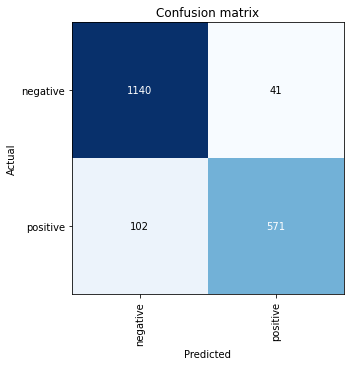

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))
plt.savefig('confusion_matrix-1.png')
mlflow.log_artifact("confusion_matrix-1.png", artifact_path="learning-rate")
# mlflow.log_figure(plt, "confusion_matrix-1a.png", artifact_path="learning-rate")

Plot top losses help you plot 10 most wrong prediction by the model, this helps you listen/visualize the sound. This helps you understand where the model is not performing the best and provide key insights. As we can listen in below examples some of these audios don't contain Orca Call but the labeling process has marked them positive and some cases where model thinks there is a Orca call but nobody tagged it as positive.

File: /home/azureuser/.fastai/cache/rs_20000/60026_923.0_927.0_call.wav-12028256200ac3a285d27a58ce0ba59f/0.wav
Total Length: 4.0 seconds
Number of Channels: 1
Label: negative/positive / 7.98 / 0.00
0.0s-4.0s of original clip


Channel 0.0 (256x312):


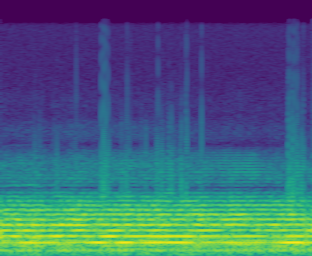

File: /home/azureuser/.fastai/cache/rs_20000/60026_927.0_931.0_call.wav-6dfd4fdcc55886723f17d0045f53a6e8/0.wav
Total Length: 4.0 seconds
Number of Channels: 1
Label: negative/positive / 7.22 / 0.00
0.01s-4.01s of original clip


Channel 0.0 (256x312):


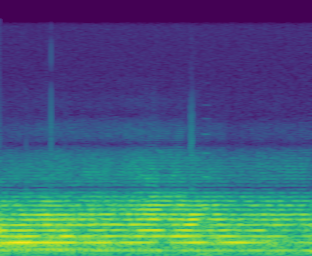

File: /home/azureuser/.fastai/cache/rs_20000/64030_374.0_377.0_call.wav-844067e8d51fa57cf1fb7d12ca6395b4/0.wav
Total Length: 3.0 seconds
Number of Channels: 1
Label: negative/positive / 5.75 / 0.00


Channel 0.0 (256x312):


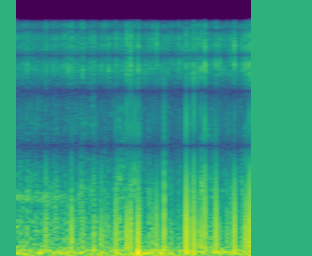

File: /home/azureuser/.fastai/cache/rs_20000/64025_289.0_293.0_call.wav-b69c91d6ff2b99c29705984996d938c0/0.wav
Total Length: 4.0 seconds
Number of Channels: 1
Label: negative/positive / 5.17 / 0.01
0.01s-4.01s of original clip


Channel 0.0 (256x312):


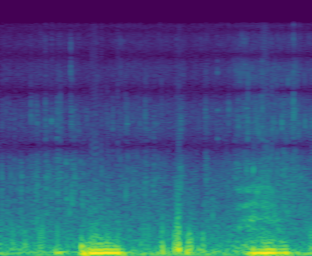

File: /home/azureuser/.fastai/cache/rs_20000/64030_402.0_405.0_call.wav-40c634fc6d85b77f6143739e09d144d8/0.wav
Total Length: 3.0 seconds
Number of Channels: 1
Label: negative/positive / 4.98 / 0.01


Channel 0.0 (256x312):


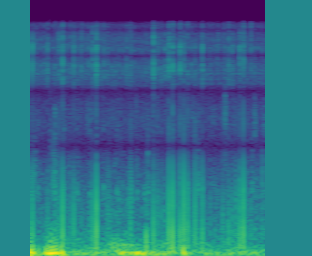

File: /home/azureuser/.fastai/cache/rs_20000/1562337136_0004_45.0_49.0_call.wav-0798e44f8f7863bbeb75efa8a2baf3db/0.wav
Total Length: 4.0 seconds
Number of Channels: 1
Label: negative/positive / 4.43 / 0.01
0.01s-4.01s of original clip


Channel 0.0 (256x312):


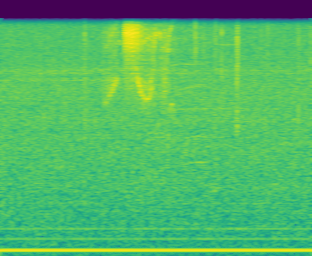

File: /home/azureuser/.fastai/cache/rs_20000/os_9_27_2017_08_09_00__0002_15.0_18.0_call.wav-103cbe94fab43f33730bd1f4e01c9cea/0.wav
Total Length: 3.0 seconds
Number of Channels: 1
Label: negative/positive / 4.36 / 0.01


Channel 0.0 (256x312):


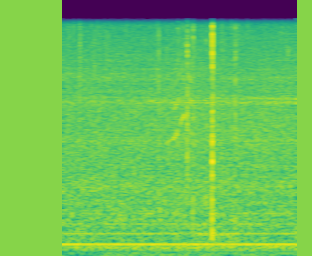

File: /home/azureuser/.fastai/cache/rs_20000/os_9_27_2017_08_09_00__0002_35.0_38.0_call.wav-8d6665ec9fb36b7864afd025cd07b0cd/0.wav
Total Length: 3.0 seconds
Number of Channels: 1
Label: negative/positive / 4.24 / 0.01


Channel 0.0 (256x312):


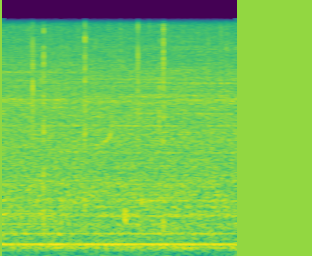

File: /home/azureuser/.fastai/cache/rs_20000/60026_1481.0_1484.0_call.wav-75f15e9e4a85025286c4c7792ef7a1f2/0.wav
Total Length: 3.0 seconds
Number of Channels: 1
Label: negative/positive / 4.10 / 0.02


Channel 0.0 (256x312):


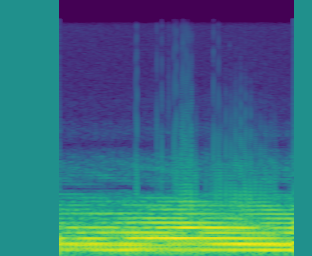

File: /home/azureuser/.fastai/cache/rs_20000/1562344334_0005_9.0_13.0_call.wav-c77f173a645c2506396f4f898ff98749/0.wav
Total Length: 4.0 seconds
Number of Channels: 1
Label: negative/positive / 3.86 / 0.02
0.0s-4.0s of original clip


Channel 0.0 (256x312):


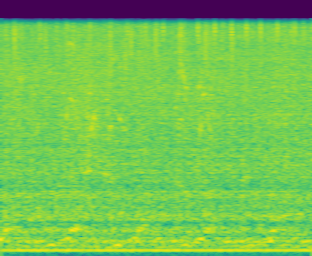

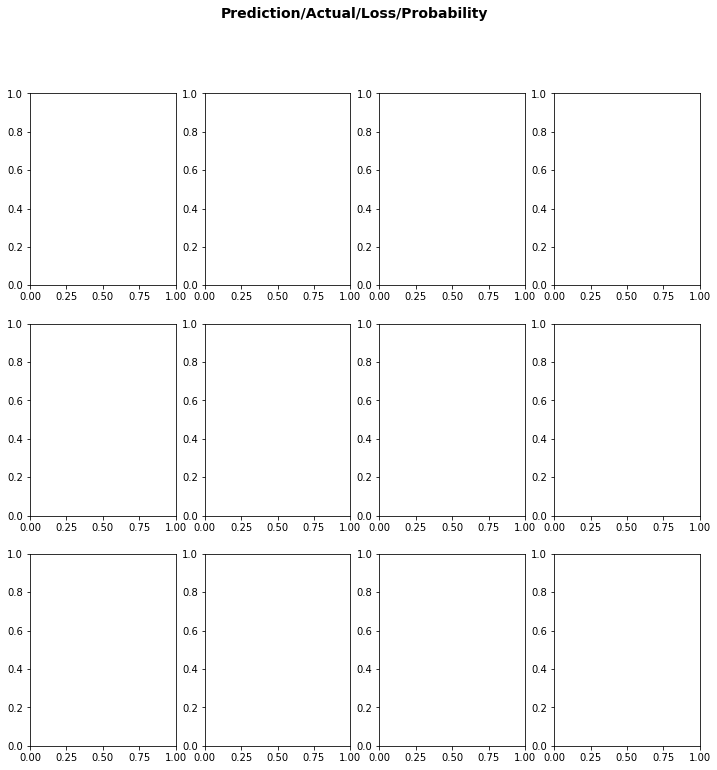

In [28]:
interp.plot_top_losses(10, heatmap = False)

## Model Evaluation on testing set

Defining DataFolder

In [29]:
testdataset = ws.datasets[test_dataset_name]

# Create mountcontext and mount the dataset
testdata_mount_ctx = testdataset.mount()  
testdata_mount_ctx.start()  

# Get the mount point
test_dataset_mount_folder = testdata_mount_ctx.mount_point
print(test_dataset_mount_folder)



Volume mount is not enabled. 
Falling back to dataflow mount.
/tmp/tmp1eq5d7pc


In [30]:
test_data_folder = Path(test_dataset_mount_folder)
test_data_folder

PosixPath('/tmp/tmp1eq5d7pc')

Creating a AudioBunch

In [31]:
test = AudioList.from_folder(test_data_folder, config=config).split_none().label_from_folder()
testdb = test.transform(tfms).databunch(bs=64)

## Also extracting true labels
true_value = pd.Series(list(testdb.train_ds.y.items))

Preprocessing: Resampling to 20000


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1281) may be set too low.
  warnings.warn(


Generating predictions : 
- **To-Do** - There should be a better way to batch scoring, write now we have to score 1 by 1

In [32]:
predictions = []
for item in tqdm_notebook(testdb.x):
    predictions.append(learn.predict(item)[2][1])

/tmp/ipykernel_236368/2468676649.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm_notebook(testdb.x):


  0%|          | 0/1219 [00:00<?, ?it/s]

Calulating performance measure

In [33]:
print("AUC Score :{0:.2f} \nF-1 Score :{1:.2f} \nAccuracy Score :{2:.2f} \nAveragePrecisionScore :{1:.2f}".format(
    roc_auc_score(true_value,pd.Series(predictions)), 
    f1_score(true_value,pd.Series(predictions)>0.5), 
    accuracy_score(true_value,pd.Series(predictions)>0.5),
    average_precision_score(true_value,pd.Series(predictions) )
))

mlflow.log_metric('AUC', roc_auc_score(true_value,pd.Series(predictions)))
mlflow.log_metric('f1',f1_score(true_value,pd.Series(predictions)>0.5))
mlflow.log_metric('accuracy', accuracy_score(true_value,pd.Series(predictions)>0.5))
mlflow.log_metric('average_precision',average_precision_score(true_value,pd.Series(predictions) ))

AUC Score :0.97 
F-1 Score :0.91 
Accuracy Score :0.93 
AveragePrecisionScore :0.91


Wohoo model seems to performing inline with our initial model training process on this test set. Let's plot a confusion matrix.

Confusion matrix, without normalization
[[676  57]
 [ 34 452]]


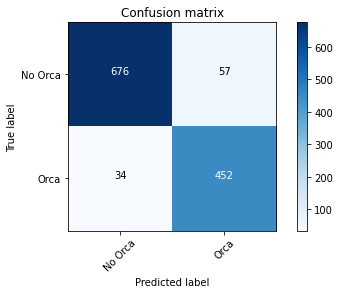

In [34]:
plot_confusion_matrix(true_value, pd.Series(predictions)>0.5, classes=["No Orca","Orca"])
plt.savefig('confusion_matrix-2.png')
mlflow.log_artifact("confusion_matrix-2.png", artifact_path="learning-rate")
# mlflow.log_figure(plt, "confusion_matrix-2a.png", artifact_path="learning-rate")

## Register ML Model in AML Model repository 

In [35]:
# log models 
mlflow.log_artifact(os.path.join(output_root_folder,model_folder_name,model_file_name), artifact_path="models")

## Scoring for official evaluation

Loading the trained model

In [7]:
learn = load_learner(os.path.join(output_root_folder,model_folder_name), model_file_name)

Loading the 2 sec audio clips generated in Data prepration step for evaluation

In [8]:
model_final_eval_dataset = ws.datasets[model_final_eval_dataset_name]
#model_final_eval_dataset = ws.datasets[benchmark_dataset_name]


# Create mountcontext and mount the dataset
model_final_eval_mount_ctx = model_final_eval_dataset.mount()  
model_final_eval_mount_ctx.start()  

# Get the mount point
model_final_eval_dataset_mount_folder = model_final_eval_mount_ctx.mount_point
print(model_final_eval_dataset_mount_folder)





Volume mount is not enabled. 
Falling back to dataflow mount.
/tmp/tmpw3eibmh6


In [9]:
# List the files in the mount point
files = os.listdir(model_final_eval_dataset_mount_folder)
print(files)

['.DS_Store', 'test - Copy.csv', 'test.tsv', 'wav-rpi', 'wav', 'wav2', 'wav3', 'wav4', 'wav5']


In [10]:
test_data_folder = Path(os.path.join(model_final_eval_dataset_mount_folder,"wav"))

# test_data_folder=model_final_eval_dataset_mount_folder
print ( os.listdir(test_data_folder))

['OS_9_27_2017_08_14_00__0001.wav', 'OS_9_27_2017_08_19_00__0002.wav', 'OS_9_27_2017_08_25_00__0003.wav', 'OS_9_27_2017_08_25_00__0004.wav', 'OS_9_27_2017_08_30_00__0001.wav', 'OS_9_27_2017_08_30_00__0002.wav', 'OS_9_27_2017_08_30_00__0003.wav', 'OS_9_27_2017_08_35_00__0004.wav', 'OS_9_27_2017_09_02_00__0002.wav', 'OS_9_27_2017_09_34_00__0002.wav', 'OS_9_27_2017_10_28_00__0001.wav', 'OS_9_27_2017_10_49_00__0003.wav', 'OS_9_27_2017_11_00_00__0004.wav', 'OS_9_27_2017_11_05_00__0000.wav', 'OS_9_27_2017_11_26_00__0000.wav', 'OS_9_27_2017_11_26_00__0002.wav', 'OS_9_27_2017_11_32_00__0002.wav', 'OS_9_27_2017_11_32_00__0003.wav', 'OS_9_27_2017_11_42_00__0000.wav', 'OS_9_27_2017_11_53_00__0001.wav', 'OS_9_27_2017_11_58_00__0003.wav']


In [13]:
## Definining Audio config needed to create on the fly mel spectograms
config = AudioConfig(standardize=False, 
                     downmix=True, ## Seperate Channel by Herman
                     sg_cfg=SpectrogramConfig(
                         f_min=0.0,  ## Minimum frequency to Display
                         f_max=10000, ## Maximum Frequency to Display
                         hop_length=256,
                         n_fft=2560, ## Number of Samples for Fourier
                         n_mels=256, ## Mel bins
                         pad=0, 
                         to_db_scale=True, ## Converting to DB sclae
                         top_db=100,  ## Top decible sound
                         win_length=None, 
                         n_mfcc=20)
                    )
config.duration = 4000 ## 4 sec padding or snip
config.resample_to=20000 ## Every sample at 20000 frequency


In [14]:

tfms=None
test = AudioList.from_folder(test_data_folder, config=config).split_none().label_empty()
testdb = test.transform(tfms).databunch(bs=64)

Preprocessing: Downmixing to Mono


Preprocessing: Resampling to 20000


You can deactivate this warning by passing `no_check=True`.


Runnning though model and generating predictions

In [22]:
predictions = []
pathList = [] 
for item in tqdm_notebook(testdb.x):
    predictions.append(learn.predict(item)[2][1])
    pathList.append(str(item.path))
    print(item.path)

/tmp/ipykernel_5246/659356200.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm_notebook(testdb.x):


  0%|          | 0/21 [00:00<?, ?it/s]

/home/azureuser/.fastai/cache/rs_20000/0.wav-3fbddf28ea3c0f13ff257f4b7c55f3f0/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-003cbb68d0be744f8fb45bb3897d2180/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-e996bb743c0651fd6e263614e2c713c5/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-618684808d5174e8a8c43e27aeaa2425/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-15f409bd87ef6a05e08dbb77b686f018/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-134f9ea30743ea14c2ebfb02f0c0a715/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-a20ee1a6da67997a1f629e62b25a53da/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-23a986aa782b01f786232611ca77201a/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-f3b0c53bc5036d97ff40fef8042758a0/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-b0ec7055ced0a1e358d5ae879b192797/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-e04f5b0b4b0b53835569499e9a61e8d3/0.wav
/home/azureuser/.fastai/cache/rs_20000/0.wav-1b15a5097f01447bcd1d70f86d3a90f

Exporing the predictions

In [16]:
prediction = pd.DataFrame({'FilePath': pathList, 'pred': predictions})
prediction['FileName'] = prediction.FilePath.apply(lambda x: x.split('/')[6].split("-")[0])
prediction.loc[:,['FileName','pred']].to_csv(os.path.join(output_root_folder,eval_pred_folder_name,'./test2Sec.csv'), index=False)

Converting the predictions in standard evaluation format

In [21]:
prediction

FilePath            pred FileName
0   /home/azureuser/.fastai/cache/rs_20000/0.wav-3...  tensor(0.0275)    0.wav
1   /home/azureuser/.fastai/cache/rs_20000/0.wav-0...  tensor(0.0086)    0.wav
2   /home/azureuser/.fastai/cache/rs_20000/0.wav-e...  tensor(0.0407)    0.wav
3   /home/azureuser/.fastai/cache/rs_20000/0.wav-6...  tensor(0.3961)    0.wav
4   /home/azureuser/.fastai/cache/rs_20000/0.wav-1...  tensor(0.9894)    0.wav
5   /home/azureuser/.fastai/cache/rs_20000/0.wav-1...  tensor(0.0441)    0.wav
6   /home/azureuser/.fastai/cache/rs_20000/0.wav-a...  tensor(0.0351)    0.wav
7   /home/azureuser/.fastai/cache/rs_20000/0.wav-2...  tensor(0.7221)    0.wav
8   /home/azureuser/.fastai/cache/rs_20000/0.wav-f...  tensor(0.9839)    0.wav
9   /home/azureuser/.fastai/cache/rs_20000/0.wav-b...  tensor(0.1250)    0.wav
10  /home/azureuser/.fastai/cache/rs_20000/0.wav-e...  tensor(0.0181)    0.wav
11  /home/azureuser/.fastai/cache/rs_20000/0.wav-1...  tensor(0.0459)    0.wav
12  /home/azureuser/.fastai/cache/rs_20000/0.wav-b...  tensor(0.0166)    0.wav
13  /home/azureuser/.fastai/cache/rs_20000/0.wav-9...  tensor(0.0031)    0.wav
14  /home/azureuser/.fastai/cache/rs_20000/0.wav-a...  tensor(0.0277)    0.wav
15  /home/azureuser/.fastai/cache/rs_20000/0.wav-f...  tensor(0.2719)    0.wav
16  /home/azureuser/.fastai/cache/rs_20000/0.wav-0...  tensor(0.1599)    0.wav
17  /home/azureuser/.fastai/cache/rs_20000/0.wav-e...  tensor(0.0176)    0.wav
18  /home/azureuser/.fastai/cache/rs_20000/0.wav-6...  tensor(0.1840)    0.wav
19  /home/azureuser/.fastai/cache/rs_20000/0.wav-b...  tensor(0.5853)    0.wav
20  /home/azureuser/.fastai/cache/rs_20000/0.wav-d...  tensor(0.0364)    0.wav

In [17]:
## Load predictions

test2secDF = pd.read_csv(os.path.join(output_root_folder,eval_pred_folder_name,'./test2Sec.csv')) 

## Clean the predictions(it got converted in string)
test2secDF['pred'] = test2secDF.pred.apply(lambda x: float(x.split('(')[1].split(')')[0])) 

In [18]:
## Extracting Start time from file name
test2secDF['startTime'] = test2secDF.FileName.apply(lambda x: int(x.split('__')[1].split('.')[0].split('_')[0]))

## Sorting the file based on startTime
test2secDF = test2secDF.sort_values(['startTime']).reset_index(drop=True)

IndexError: list index out of range

In [19]:
test2secDF.head()

FileName    pred
0    0.wav  0.0275
1    0.wav  0.0086
2    0.wav  0.0407
3    0.wav  0.3961
4    0.wav  0.9894

In [20]:
test2secDF.shape

(21, 2)

In [44]:
## Rolling Window (to average at per second level)
submission = pd.DataFrame({'pred': list(test2secDF.rolling(2)['pred'].mean().values)}).reset_index().rename(columns={'index':'StartTime'})

## Updating first row
submission.loc[0,'pred'] = test2secDF.pred[0]

## Adding lastrow
lastLine = pd.DataFrame({'StartTime':[submission.StartTime.max()+1],'pred':[test2secDF.pred[test2secDF.shape[0]-1]]})
submission = submission.append(lastLine, ignore_index=True)

finalSubmission = submission.loc[submission.pred > 0.5,:].reset_index(drop=True)
finalSubmission['Duration'] = 1

In [45]:
## Final submission file
finalSubmission.loc[:,['StartTime','Duration']].to_csv(os.path.join(output_root_folder,eval_pred_folder_name,submission_file_name), index=False)

In [46]:
# log submission 
mlflow.log_artifact(os.path.join(output_root_folder,eval_pred_folder_name,submission_file_name), artifact_path="submissioni")

In [47]:
mlflow.set_tags(params)

In [48]:
mlflow.end_run()